In [1]:
#pip install opencv-python
import keras
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.utils import load_img,img_to_array
#from keras.preprocessing.image import load_img,img_to_array

from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_error

from tensorflow.keras.initializers import RandomNormal
#from keras.initializers import RandomNormal

from tensorflow.keras.applications.vgg16 import VGG16
#rom keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD

from tensorflow.keras.models import Model,Sequential
#from keras.models import Model,Sequential

from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import numpy as np

In [2]:
K.clear_session()
root = r'C:\Users\oriol\ShanghaiTec'

In [3]:
'''
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
'''
part_A_train = os.path.join(root,'part_A_final\\train_data','images')
part_A_test = os.path.join(root,'part_A_final\\test_data','images')
part_B_train = os.path.join(root,'part_B_final\\train_data','images')
part_B_test = os.path.join(root,'part_B_final\\test_data','images')
temp = 'test_images'
path_sets = [part_A_train]

In [4]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        img_paths.append(str(img_path))
        
print("Total images : ",len(img_paths))

Total images :  300


In [5]:
######################Reduimos 10 imagenes
img_paths = img_paths[0:10]
print("Total images : ",len(img_paths))

Total images :  10


In [6]:
def fix_singular_shape(img, unit_len=16):
    """
    Some network like w-net has both N maxpooling layers and concatenate layers,
    so if no fix for their shape as integeral times of 2 ** N, the shape will go into conflict.
    """
    hei_dst, wid_dst = img.shape[0] + ((unit_len - img.shape[0] % unit_len)%unit_len), img.shape[1] + ((unit_len - img.shape[1] % unit_len)%unit_len)
    if len(img.shape) == 3:
        img = cv2.resize(img, (wid_dst, hei_dst), interpolation=cv2.INTER_LANCZOS4)
    elif len(img.shape) == 2:
        GT = int(round(np.sum(img)))
        img = cv2.resize(img, (wid_dst, hei_dst), interpolation=cv2.INTER_LANCZOS4)
        img = img / (np.sum(img) / GT)
    return img


def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')

    im = np.array(im)
    ########################################################## resize
    im = fix_singular_shape(im, unit_len=16)
    ##########################################################    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    #print('img',img.shape)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    #print('antes',img.shape)
    #img = np.expand_dims(img,axis  = 3)
    img = np.expand_dims(img,axis  = 2)
    
    #print('despues',img.shape)
    
    return img
    
    
'''    
def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)
'''      

'    \ndef preprocess_input(image,target):\n    #crop image\n    #crop target\n    #resize target\n    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))\n    \n    \n    if random.randint(0,9)<= -1:            \n            dx = int(random.randint(0,1)*image.shape[0]*1./2)\n            dy = int(random.randint(0,1)*image.shape[1]*1./2)\n    else:\n            dx = int(random.random()*image.shape[0]*1./2)\n            dy = int(random.random()*image.shape[1]*1./2)\n\n    #print(crop_size , dx , dy)\n    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]\n    \n    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]\n    #print(img.shape)\n\n    return(img,target_aug)\n'

In [7]:
#Image data generator 
def image_generator(files, batch_size = 64):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','ground_truth') )
            
       
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        print('batch_x-y',batch_x.shape,batch_y.shape)
        yield( batch_x, batch_y )


In [8]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [9]:
def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    
    json_file = open('models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)
    

In [10]:
def euclidean_distance_loss(y_true, y_pred):
    print('rttot',(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))))
    #print(str(np.sum(y_pred)))
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    #return np.sqrt(np.sum(np.square(y_pred - y_true), axis=-1))


#print(euclidean_distance_loss(np.asarray([[1.,1.],[1.,1.]]),np.asarray([[1.,3.],[1.,2.]])))

In [11]:
# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
            
            model = init_weights_vgg(model)
            
            return model

In [12]:
model = CrowdNet()

c:\Users\oriol\anaconda3\envs\aI_Keras\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\oriol\anaconda3\envs\aI_Keras\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                    

In [14]:
train_gen = image_generator(img_paths,1)

In [15]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
#model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'],run_eagerly=True,)

In [16]:
#a=1/0


In [17]:
#model.fit_generator(train_gen,epochs=1,steps_per_epoch= 700 , verbose=1)
model.fit(train_gen,epochs=1,steps_per_epoch= 2 , verbose=1)

batch_x-y (1, 768, 1024, 3) (1, 96, 128, 1)
rttot Tensor("euclidean_distance_loss/Sqrt:0", shape=(None, None, None), dtype=float32)
rttot Tensor("euclidean_distance_loss/Sqrt:0", shape=(None, None, None), dtype=float32)
batch_x-y (1, 400, 400, 3) (1, 50, 50, 1)
2/2 [==============================] - 14s 2s/step - loss: 0.0198 - mse: 0.0047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dim 3 768 1024 3
1/1 [==============================] - 2s 2s/step


<Figure size 640x480 with 0 Axes>

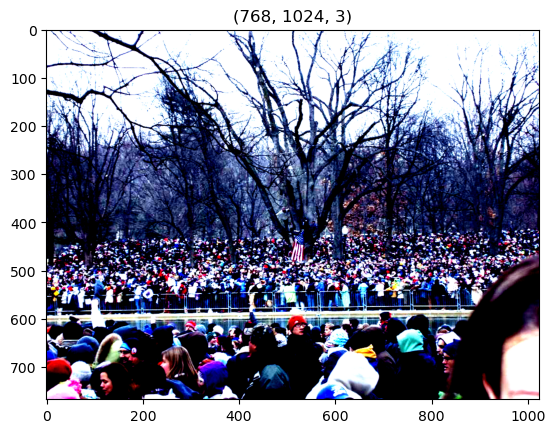

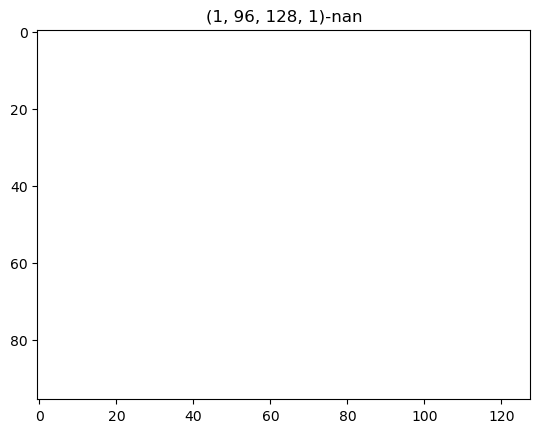

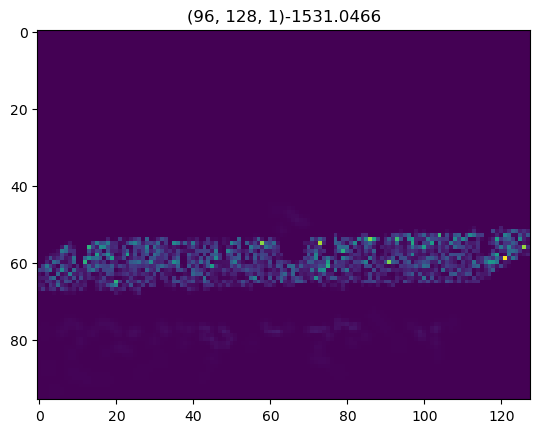

<Figure size 640x480 with 0 Axes>

In [18]:
#####################################333
#Test
#########################################3

def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    #model = load_model()
    image = create_img(path)
    ans = model.predict(image)
    #ans = model.predict(1)
    count = np.sum(ans)
    return count,image,ans

#ans,img,hmap = predict('data/part_A_final/test_data/images/IMG_170.jpg')
img5 = create_img(r'C:\Users\oriol\ShanghaiTec\part_A_final\train_data\images\IMG_1.jpg')
print("dim",img5.ndim,img5.shape[0],img5.shape[1],img5.shape[2])
plt.title(img5.shape)
plt.imshow(img5)
plt.figure()
batch_input = []
batch_input += [img5]
batch_x = np.array( batch_input )
ans = model.predict(batch_x,batch_size=1,verbose=True)
#ans=Model.predict_on_batch(1)
#print(ans)
plt.title(str(ans.shape)+'-'+str(np.sum(ans)))
plt.imshow(ans.reshape(ans.shape[1],ans.shape[2],ans.shape[3]))
plt.figure()
#ans,img,hmap = predict(r'C:\Users\oriol\Documents\Python Scripts\CSRNet-keres-master\data\ShanghaiTec\part_A_final\train_data\images\IMG_1.jpg')
obj = get_output(r'C:\Users\oriol\ShanghaiTec\part_A_final\train_data\ground_truth\IMG_1.h5')
plt.title(str(obj.shape)+'-'+str(np.sum(obj)))
plt.imshow(obj)
#plt.imshow(obj.reshape(obj.shape[1],obj.shape[2],obj.shape[3]))
plt.figure()

In [19]:
save_mod(model,"weights/model_A_weights.h5","models/Model.json")